In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [2]:
# List of Indian company stock symbols
companies = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'VOLTAS.NS', 'PIDILITIND.NS', 'MPHASIS.NS', 'DIXON.NS', 'IEX.NS', 'BALAMINES.NS', 'LTTS.NS']



In [3]:
def fetch_data(tickers, start='2023-01-01', end='2025-03-01'):
    data = {}
    for ticker in tickers:
        stock = yf.download(ticker, start=start, end=end, progress=False)
        if not stock.empty:
            data[ticker] = stock['Close']
        else:
            print(f"Warning: No data for {ticker}")
    
    if not data:  # Check if data dictionary is empty
        raise ValueError("No valid stock data retrieved. Check ticker symbols or API limits.")
    
    return pd.concat(data.values(), axis=1, keys=data.keys())

# Fetch historical stock data
data = fetch_data(companies)
data.dropna(inplace=True)  # Remove missing values
print(data.head())  # Debugging output


YF.download() has changed argument auto_adjust default to True
            RELIANCE.NS       TCS.NS  HDFCBANK.NS   VOLTAS.NS PIDILITIND.NS  \
Ticker      RELIANCE.NS       TCS.NS  HDFCBANK.NS   VOLTAS.NS PIDILITIND.NS   
Date                                                                          
2023-01-02  1172.422974  3152.531738  1588.541626  795.509033   2506.679199   
2023-01-03  1163.843262  3200.765625  1598.929199  801.108704   2513.614746   
2023-01-04  1146.320068  3203.955322  1570.351562  798.680542   2487.804932   
2023-01-05  1144.271851  3200.524170  1560.256836  802.248535   2494.889160   
2023-01-06  1154.672119  3104.298828  1555.087524  807.303162   2499.050293   

             MPHASIS.NS     DIXON.NS      IEX.NS BALAMINES.NS      LTTS.NS  
Ticker       MPHASIS.NS     DIXON.NS      IEX.NS BALAMINES.NS      LTTS.NS  
Date                                                                        
2023-01-02  1877.429321  3893.496826  136.444992  2622.940674  3643.87939

In [4]:

# Feature Engineering: Create moving averages for all companies
for company in companies:
    data[f'{company}_50MA'] = data[company].rolling(window=50).mean()
    data[f'{company}_200MA'] = data[company].rolling(window=200).mean()



In [5]:
print(data.columns.tolist())  # Check all column names


[('RELIANCE.NS', 'RELIANCE.NS'), ('TCS.NS', 'TCS.NS'), ('HDFCBANK.NS', 'HDFCBANK.NS'), ('VOLTAS.NS', 'VOLTAS.NS'), ('PIDILITIND.NS', 'PIDILITIND.NS'), ('MPHASIS.NS', 'MPHASIS.NS'), ('DIXON.NS', 'DIXON.NS'), ('IEX.NS', 'IEX.NS'), ('BALAMINES.NS', 'BALAMINES.NS'), ('LTTS.NS', 'LTTS.NS'), ('RELIANCE.NS_50MA', ''), ('RELIANCE.NS_200MA', ''), ('TCS.NS_50MA', ''), ('TCS.NS_200MA', ''), ('HDFCBANK.NS_50MA', ''), ('HDFCBANK.NS_200MA', ''), ('VOLTAS.NS_50MA', ''), ('VOLTAS.NS_200MA', ''), ('PIDILITIND.NS_50MA', ''), ('PIDILITIND.NS_200MA', ''), ('MPHASIS.NS_50MA', ''), ('MPHASIS.NS_200MA', ''), ('DIXON.NS_50MA', ''), ('DIXON.NS_200MA', ''), ('IEX.NS_50MA', ''), ('IEX.NS_200MA', ''), ('BALAMINES.NS_50MA', ''), ('BALAMINES.NS_200MA', ''), ('LTTS.NS_50MA', ''), ('LTTS.NS_200MA', '')]


In [6]:
# Flatten MultiIndex columns correctly
data.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in data.columns]

# Print columns to verify
print(data.columns)

# Identify correct column names dynamically
reliance_50ma_col = next((col for col in data.columns if 'RELIANCE' in col and '50MA' in col), None)
reliance_200ma_col = next((col for col in data.columns if 'RELIANCE' in col and '200MA' in col), None)
reliance_price_col = next((col for col in data.columns if 'RELIANCE.NS' in col and 'RELIANCE.NS' in col), None)

# Ensure columns are found
if not reliance_50ma_col or not reliance_200ma_col or not reliance_price_col:
    raise ValueError(f"Missing columns: 50MA={reliance_50ma_col}, 200MA={reliance_200ma_col}, Price={reliance_price_col}")

# Print selected columns
print("50MA Column:", reliance_50ma_col)
print("200MA Column:", reliance_200ma_col)
print("Stock Price Column:", reliance_price_col)

# Prepare data for regression analysis
X = data[[reliance_50ma_col, reliance_200ma_col]].dropna()
y = data[reliance_price_col][X.index]  # Ensure matching index

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Index(['RELIANCE.NS_RELIANCE.NS', 'TCS.NS_TCS.NS', 'HDFCBANK.NS_HDFCBANK.NS',
       'VOLTAS.NS_VOLTAS.NS', 'PIDILITIND.NS_PIDILITIND.NS',
       'MPHASIS.NS_MPHASIS.NS', 'DIXON.NS_DIXON.NS', 'IEX.NS_IEX.NS',
       'BALAMINES.NS_BALAMINES.NS', 'LTTS.NS_LTTS.NS', 'RELIANCE.NS_50MA',
       'RELIANCE.NS_200MA', 'TCS.NS_50MA', 'TCS.NS_200MA', 'HDFCBANK.NS_50MA',
       'HDFCBANK.NS_200MA', 'VOLTAS.NS_50MA', 'VOLTAS.NS_200MA',
       'PIDILITIND.NS_50MA', 'PIDILITIND.NS_200MA', 'MPHASIS.NS_50MA',
       'MPHASIS.NS_200MA', 'DIXON.NS_50MA', 'DIXON.NS_200MA', 'IEX.NS_50MA',
       'IEX.NS_200MA', 'BALAMINES.NS_50MA', 'BALAMINES.NS_200MA',
       'LTTS.NS_50MA', 'LTTS.NS_200MA'],
      dtype='object')
50MA Column: RELIANCE.NS_50MA
200MA Column: RELIANCE.NS_200MA
Stock Price Column: RELIANCE.NS_RELIANCE.NS


In [7]:

# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Linear Regression RMSE: 57.97044343123567


In [ ]:
import ta

# Adding new features
data['RELIANCE_50EMA'] = ta.trend.ema_indicator(data[reliance_price_col], window=50)
data['RELIANCE_RSI'] = ta.momentum.rsi(data[reliance_price_col], window=14)
data['RELIANCE_MACD'] = ta.trend.macd(data[reliance_price_col])
data['RELIANCE_BB_Upper'] = ta.volatility.bollinger_hband(data[reliance_price_col])
data['RELIANCE_BB_Lower'] = ta.volatility.bollinger_lband(data[reliance_price_col])

# Updating feature set
X = data[['RELIANCE.NS_50MA', 'RELIANCE.NS_200MA', 'RELIANCE_50EMA', 'RELIANCE_RSI', 'RELIANCE_MACD', 'RELIANCE_BB_Upper', 'RELIANCE_BB_Lower']].dropna()
y = data[reliance_price_col][X.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train new model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# New RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Improved Linear Regression RMSE:", rmse)


Improved Linear Regression RMSE: 7.042415261730638


In [13]:
import plotly.graph_objects as go

# Create interactive Plotly figure
fig = go.Figure()

# Add actual stock price trace
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, 
                         mode='lines', name='Actual Price',
                         line=dict(color='blue')))

# Add predicted stock price trace
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred, 
                         mode='lines', name='Predicted Price',
                         line=dict(color='red', dash='dot')))  # Dashed line for prediction

# Update layout
fig.update_layout(title="Stock Price: Actual vs Predicted",
                  xaxis_title="Date",
                  yaxis_title="Stock Price",
                  legend=dict(x=0, y=1),
                  template="plotly_dark")  # Dark theme for better contrast

# Show the interactive plot
fig.show()


In [15]:
import pandas as pd

# Create a DataFrame with Actual and Predicted values
results_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred}, index=y_test.index)


# If using Jupyter Notebook, display a nicer table
from IPython.display import display
display(results_df.head(20))  # Show first 20 rows


,Actual Price,Predicted Price
Date,,
2024-01-17,1352.363892,1363.869589
2025-02-03,1245.900024,1248.952978
2024-08-07,1454.915405,1455.529499
2024-11-14,1267.599976,1268.080292
2024-12-09,1295.150024,1300.858964
2024-08-26,1512.599976,1516.993620
2025-02-25,1204.000000,1188.429575
2024-04-25,1450.098267,1451.162884
2024-10-23,1338.525024,1341.188053


In [ ]:

# Decision Tree Model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))


Decision Tree RMSE: 22.106237278845015


In [ ]:
# Identify the correct column for RELIANCE.NS
reliance_price_col = next((col for col in data.columns if 'RELIANCE.NS' in col and 'RELIANCE.NS' in col), None)

# Ensure the column was found
if not reliance_price_col:
    raise ValueError("Could not find RELIANCE.NS column in data")

# Print the detected column name
print("Using column:", reliance_price_col)

# ARIMA Time Series Forecasting
arima_model = ARIMA(data[reliance_price_col].dropna(), order=(5,1,0))
arima_result = arima_model.fit()
forecast = arima_result.forecast(steps=10)

print("ARIMA Forecast:", forecast)


Using column: RELIANCE.NS_RELIANCE.NS


c:\Users\NIKHIL SINGH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\NIKHIL SINGH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\NIKHIL SINGH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA Forecast: 534    1201.284424
535    1201.631369
536    1202.962269
537    1202.428726
538    1202.963390
539    1202.757249
540    1202.819601
541    1202.668422
542    1202.742024
543    1202.689713
Name: predicted_mean, dtype: float64


c:\Users\NIKHIL SINGH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\NIKHIL SINGH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



c:\Users\NIKHIL SINGH\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



Using columns:
Stock Price Column: RELIANCE.NS_RELIANCE.NS
50MA Column: RELIANCE.NS_50MA


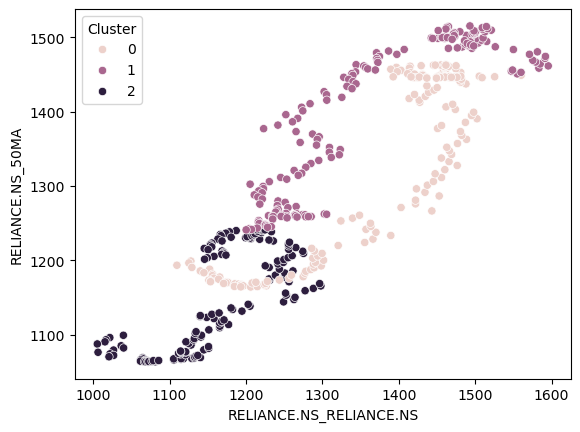

In [ ]:
# Identify the correct columns dynamically
reliance_price_col = next((col for col in data.columns if 'RELIANCE.NS' in col and 'RELIANCE.NS' in col), None)
reliance_50ma_col = next((col for col in data.columns if 'RELIANCE' in col and '50MA' in col), None)

# Ensure the columns exist
if not reliance_price_col or not reliance_50ma_col:
    raise ValueError("Could not find the required columns in data")

# Print detected column names for debugging
print("Using columns:")
print("Stock Price Column:", reliance_price_col)
print("50MA Column:", reliance_50ma_col)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data.fillna(0))

# Scatter plot with correct column names
sns.scatterplot(data=data, x=reliance_price_col, y=reliance_50ma_col, hue='Cluster')
plt.show()


In [ ]:

# Neural Network (LSTM)
n_features = 1
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(10, n_features)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
# Note: Further data transformation is needed for LSTM training.

print("Stock Prediction Models Implemented Successfully!")


c:\Users\NIKHIL SINGH\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Stock Prediction Models Implemented Successfully!


In [ ]:
# Identify the correct stock price column dynamically
reliance_col = [col for col in data.columns if 'RELIANCE' in col and 'NS' in col][0]

# Interactive Stock Price Visualization
fig = px.line(data, x=data.index, y=reliance_col, title='Reliance Stock Price Over Time')
fig.show()
